In [12]:
import numpy as np
import pandas as pd
import pm4py


def import_xes(file_path):
    log = pm4py.read_xes(file_path)
    return pm4py.convert_to_dataframe(log)


# Loading dataset, keeping only relevant data, grouping on resource
event_log_2013 = import_xes("datasets/BPI_Challenge_2013_incidents.xes")
df_2013 = event_log_2013[['case:concept:name', 'concept:name', 'org:resource', 'time:timestamp']]
df_2013 = df_2013.sort_values(by=['org:resource', 'time:timestamp'])

event_log_2017 = import_xes("datasets/BPI_Challenge_2017.xes")
event_log_2017.info()
event_log_2017.describe(include="all")

parsing log, completed traces :: 100%|██████████| 31509/31509 [00:20<00:00, 1537.38it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202267 entries, 0 to 1202266
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   Action                 1202267 non-null  object             
 1   org:resource           1202267 non-null  object             
 2   concept:name           1202267 non-null  object             
 3   EventOrigin            1202267 non-null  object             
 4   EventID                1202267 non-null  object             
 5   lifecycle:transition   1202267 non-null  object             
 6   time:timestamp         1202267 non-null  datetime64[ns, UTC]
 7   case:LoanGoal          1202267 non-null  object             
 8   case:ApplicationType   1202267 non-null  object             
 9   case:concept:name      1202267 non-null  object             
 10  case:RequestedAmount   1202267 non-null  float64            
 11  FirstWithdrawalAmount  4

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
count,1202267,1202267,1202267,1202267,1202267,1202267,1202267,1202267,1202267,1202267,1.202267e+06,42995.000000,42995.000000,42995,42995.000000,42995,42995.000000,42995.000000,150854
unique,5,149,26,3,1202267,7,NaN,14,2,31509,NaN,NaN,NaN,2,NaN,2,NaN,NaN,42995
top,statechange,User_1,W_Validate application,Workflow,Application_652823628,complete,NaN,Car,New credit,Application_2037628374,NaN,NaN,NaN,True,NaN,True,NaN,NaN,Offer_148581083
freq,358940,148404,209496,768823,1,475306,NaN,339798,1083767,180,NaN,NaN,NaN,30136,NaN,21768,NaN,NaN,4
mean,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-16 16:21:26.112857344+00:00,NaN,NaN,NaN,1.675947e+04,8394.338979,83.041982,NaN,281.403309,NaN,318.645912,18513.719940,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,NaN,NaN,NaN,0.000000e+00,0.000000,5.000000,NaN,43.050000,NaN,0.000000,5000.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-20 08:23:56.583500032+00:00,NaN,NaN,NaN,6.000000e+03,0.000000,56.000000,NaN,152.820000,NaN,0.000000,8800.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-20 15:22:00.152000+00:00,NaN,NaN,NaN,1.400000e+04,5000.000000,77.000000,NaN,244.520000,NaN,0.000000,15000.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-11 09:52:18.233499904+00:00,NaN,NaN,NaN,2.300000e+04,12000.000000,120.000000,NaN,350.000000,NaN,848.000000,25000.000000,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,2017-02-01 14:11:03.499000+00:00,NaN,NaN,NaN,4.500000e+05,75000.000000,180.000000,NaN,6673.830000,NaN,1145.000000,75000.000000,NaN


In [13]:
print(df_2013.columns)
print(df_2013["concept:name"].unique())

Index(['case:concept:name', 'concept:name', 'org:resource', 'time:timestamp'], dtype='object')
['Accepted' 'Queued' 'Completed' 'Unmatched']


<h3>One-Hot Encoding the dataset</h3>	


In [14]:
df_2013['next_activity'] = df_2013.groupby('org:resource')['concept:name'].shift(-1)
df_2013 = df_2013.dropna(subset=['next_activity'])


# Encoding the 'concept:name' column, as these are the activities
column_to_encode = 'concept:name'

# Apply one-hot encoding using pandas get_dummies
df_2013_encoded = pd.get_dummies(df_2013, columns=[column_to_encode], prefix='activity')
df_encoded = pd.get_dummies(df_2013_encoded, columns=['org:resource'], prefix='resource')

print("Columns in final dataframe:")
print(df_encoded.columns.tolist())

Columns in final dataframe:
['case:concept:name', 'time:timestamp', 'next_activity', 'activity_Accepted', 'activity_Completed', 'activity_Queued', 'activity_Unmatched', 'resource_-', 'resource_Aaron', 'resource_Abby', 'resource_Abdul', 'resource_Abhijit', 'resource_Abhimanyu', 'resource_Abhinav', 'resource_Abhiseka', 'resource_Abhishek', 'resource_Achuthanandan', 'resource_Adam', 'resource_Adeline', 'resource_Adenilson', 'resource_Aditi', 'resource_Adriano', 'resource_Adrien', 'resource_Agata', 'resource_Agneta', 'resource_Agnieszka', 'resource_Agnivesh', 'resource_Agoritsa', 'resource_Agron', 'resource_Ajay', 'resource_Ajitkumar', 'resource_Akanksha', 'resource_Akiko', 'resource_Akim', 'resource_Akshata', 'resource_Ala', 'resource_Alain', 'resource_Alan', 'resource_Alejandro', 'resource_Aleksander', 'resource_Aleksandra', 'resource_Alex', 'resource_Alexander', 'resource_Alexandra', 'resource_Alexandre', 'resource_Alexey', 'resource_Alexsandra', 'resource_Alf', 'resource_Aline', 'resou

<h4> Training Random Forest Model </h4>


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

feature_columns = [col for col in df_2013_encoded.columns if col.startswith('activity_') or col.startswith('resource')]
X = df_2013_encoded[feature_columns]
y = df_2013_encoded['next_activity']

print(f"Input Shape: {X.shape}") # Should be (Rows, Count of OHE columns)
print(f"Target Shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=1,
    stratify=y
)

rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

print("Training model...")
rf_model.fit(X_train, y_train)
print("Model trained!")

y_pred = rf_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred))

Input Shape: (64093, 4)
Target Shape: (64093,)
Training model...
Model trained!
Accuracy: 0.63

--- Detailed Classification Report ---
              precision    recall  f1-score   support

    Accepted       0.65      0.85      0.74      7792
   Completed       0.53      0.51      0.52      2773
      Queued       0.00      0.00      0.00      2254

    accuracy                           0.63     12819
   macro avg       0.39      0.45      0.42     12819
weighted avg       0.51      0.63      0.56     12819



/Users/gijskoppenberg/Documents/UU Jaar 4/OZP/Resource-Centric-NAP/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gijskoppenberg/Documents/UU Jaar 4/OZP/Resource-Centric-NAP/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gijskoppenberg/Documents/UU Jaar 4/OZP/Resource-Centric-NAP/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

<h4> Feature Importance Insight </h4>
How does the specific identity of the resource matter for prediction?

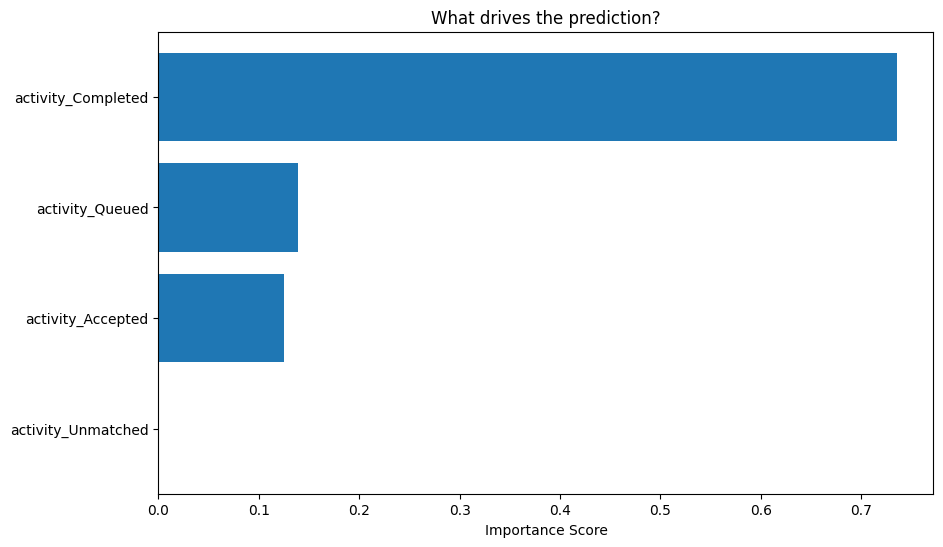

In [16]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature' : X.columns,
    'Importance' : importances,
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10))
plt.gca().invert_yaxis() # Highest importance at the top
plt.title("What drives the prediction?")
plt.xlabel("Importance Score")
plt.show()